# Faces-HQ 

In this notebook we show the results for Faces-HQ. You can create from scratch the features or use the pre-computed ones.

### 1. Create feature

If you want to create the features, first of all download the data from [link](https://cutt.ly/6enDLYG). Be sure to save the folder together with this notebook. 

Otherwise, just jump to section 2.

In [1]:
import cv2
import numpy as np
import os
import radialProfile
import glob
from matplotlib import pyplot as plt
import pickle


path = ['thispersondoesntexists', '100KFake','Flickr-Faces-HQ2_', 'celebA-HQ_10K']
labels = [1,1,0,0]
format_file = ['jpg','jpg','jpg', 'jpg']
epsilon = 1e-8
data = {}
#number of samples from each dataset
stop = 250
number_iter = 4 * stop
psd1D_total = np.zeros([number_iter, 722])
label_total = np.zeros([number_iter])
iter_ = 0

for z in range(4):
    cont = 0
    psd1D_average_org = np.zeros(722)
    print(path[z])
    
    for filename in glob.glob(path[z]+"/*."+format_file[z]):  
        img = cv2.imread(filename,0)
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        fshift += epsilon

        magnitude_spectrum = 20*np.log(np.abs(fshift))

        # Calculate the azimuthally averaged 1D power spectrum
        psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)
        psd1D_total[iter_,:] = psd1D
        label_total[iter_] = labels[z]

        cont+=1
        iter_+=1
        if cont >= stop:
            break

data["data"] = psd1D_total
data["label"] = label_total

output = open('dataset_freq_1000.pkl', 'wb')
pickle.dump(data, output)
output.close()
print("DATA Saved")    

thispersondoesntexists
100KFake
Flickr-Faces-HQ2_
celebA-HQ_10K
DATA Saved


### 2. Loading Features

Now, we load the features. Either the pre-computed ones or the features that you have created.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# load feature file
pkl_file = open('dataset_freq_1000.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

We look at the label distribution, to be sure that we have a balanced dataset.

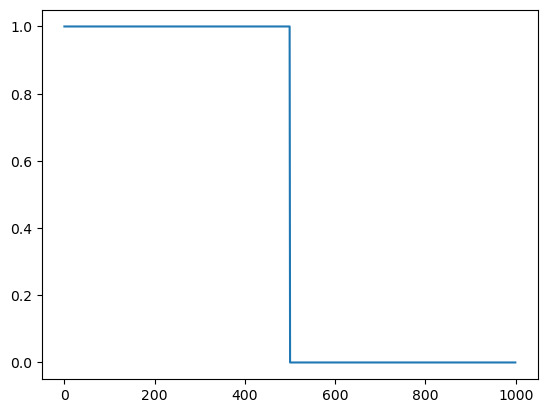

In [4]:
plt.plot(y)

### 3. Check Spectrum

We have a look to the spectrum

Text(0, 0.5, 'Power Spectrum')

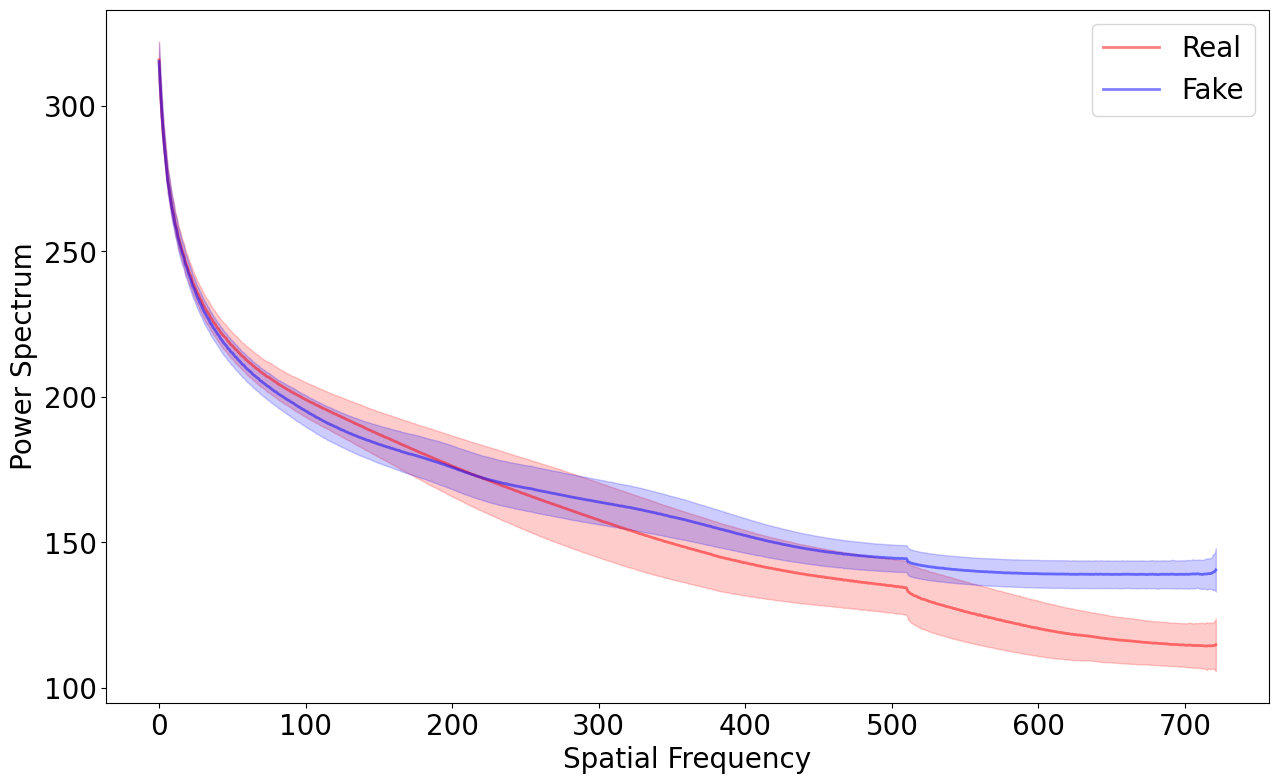

In [5]:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])
    
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)
ax.legend()
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)

### 4. Classification

Now we classify using the features.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

num = 10
LR = 0
SVM = 0


for z in range(num):
    
    pkl_file = open('dataset_freq_1000.pkl', 'rb')
    
    data = pickle.load(pkl_file)

    pkl_file.close()
    X = data["data"]
    y = data["label"]

    try:

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

        from sklearn.svm import SVC
        svclassifier = SVC(kernel='linear')
        svclassifier.fit(X_train, y_train)
        
        
        from sklearn.linear_model import LogisticRegression
        logreg = LogisticRegression(solver='liblinear', max_iter=1000)
        logreg.fit(X_train, y_train)
        

        
        SVM+=svclassifier.score(X_test, y_test)
        LR+=logreg.score(X_test, y_test)

 
    except:
        num-=1
        print(num)
    
print("Average SVM: "+str(SVM/num))
print("Average LR: "+str(LR/num))

Average SVM: 1.0
Average LR: 1.0


## Test on real images

In [7]:
def extract_features(image):
    hist, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    return hist

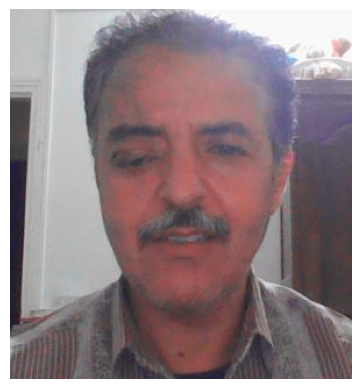

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your image file
image_path = "C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\real.jpg"

# Load the image
image = mpimg.imread(image_path)

# Plot the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [9]:
# Normalize the features using the statistics computed earlier
normalized_features = np.zeros_like(psd1D_org_0_mean[:256])
epsilon = 1e-8  # Small epsilon value to avoid division by zero
for i in range(len(normalized_features)):
    normalized_features[i] = (extract_features(image)[i] - psd1D_org_0_mean[i]) / (psd1D_org_0_std[i] + epsilon)

In [10]:
# Reshape the features to match the classifier's input shape
reshaped_features = normalized_features.reshape(1, -1)

In [11]:
print(reshaped_features.size)

256


In [12]:
expected_features=722
padded_x = np.pad(reshaped_features, (0, expected_features - reshaped_features.size), mode='constant')
reshaped_x = np.reshape(padded_x, (expected_features, -1))

In [13]:
padded_x.size

337174

In [14]:
svm_prediction = svclassifier.predict(padded_x)

In [15]:
print(svm_prediction[0])

1.0


In [16]:
Lr_prediction=logreg.predict(padded_x)

In [17]:
print(Lr_prediction[0])

1.0


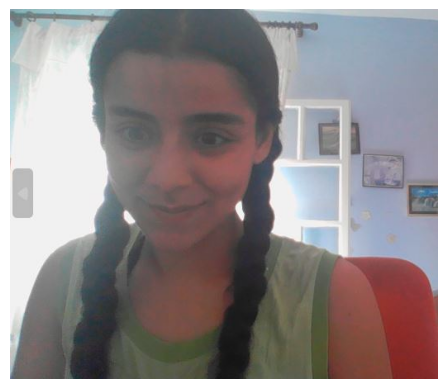

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your image file
image_path = "C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\real7.jpg"

# Load the image
image = mpimg.imread(image_path)

# Plot the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [19]:
# Normalize the features using the statistics computed earlier
normalized_features = np.zeros_like(psd1D_org_0_mean[:256])
epsilon = 1e-8  # Small epsilon value to avoid division by zero
for i in range(len(normalized_features)):
    normalized_features[i] = (extract_features(image)[i] - psd1D_org_0_mean[i]) / (psd1D_org_0_std[i] + epsilon)

In [20]:
# Reshape the features to match the classifier's input shape
reshaped_features = normalized_features.reshape(1, -1)

In [21]:
print(reshaped_features.size)

256


In [22]:
expected_features=722
padded_x = np.pad(reshaped_features, (0, expected_features - reshaped_features.size), mode='constant')
reshaped_x = np.reshape(padded_x, (expected_features, -1))

In [23]:
svm_prediction = svclassifier.predict(padded_x)

In [24]:
print(svm_prediction[0])

1.0


In [25]:
Lr_prediction=logreg.predict(padded_x)

In [26]:
print(Lr_prediction[0])

1.0


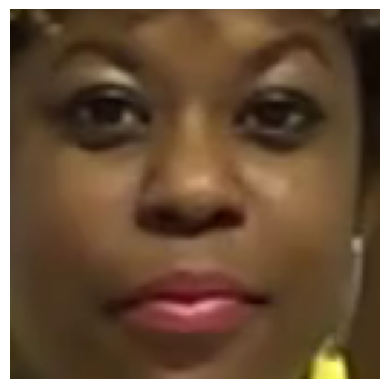

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your image file
image_path = "C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\dataset\\real\\realaytzyidmgs_0.png"

# Load the image
image = mpimg.imread(image_path)

# Plot the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [28]:
# Normalize the features using the statistics computed earlier
normalized_features = np.zeros_like(psd1D_org_0_mean[:256])
epsilon = 1e-8  # Small epsilon value to avoid division by zero
for i in range(len(normalized_features)):
    normalized_features[i] = (extract_features(image)[i] - psd1D_org_0_mean[i]) / (psd1D_org_0_std[i] + epsilon)

In [29]:
# Reshape the features to match the classifier's input shape
reshaped_features = normalized_features.reshape(1, -1)

In [30]:
expected_features=722
padded_x = np.pad(reshaped_features, (0, expected_features - reshaped_features.size), mode='constant')
reshaped_x = np.reshape(padded_x, (expected_features, -1))

In [31]:
svm_prediction = svclassifier.predict(padded_x)

In [32]:
print(svm_prediction[0])

0.0


In [33]:
Lr_prediction=logreg.predict(padded_x)

In [34]:
print(Lr_prediction[0])

0.0


## Test on fake images

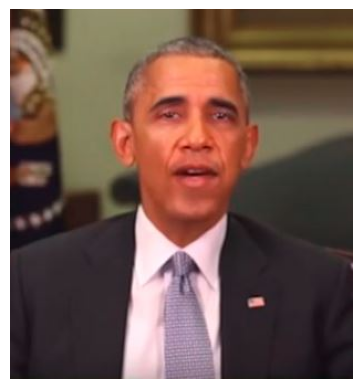

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your image file
image_path = "C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\kaggle\\test.jpg"

# Load the image
image = mpimg.imread(image_path)

# Plot the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [36]:
# Normalize the features using the statistics computed earlier
normalized_features = np.zeros_like(psd1D_org_0_mean[:256])
epsilon = 1e-8  # Small epsilon value to avoid division by zero
for i in range(len(normalized_features)):
    normalized_features[i] = (extract_features(image)[i] - psd1D_org_0_mean[i]) / (psd1D_org_0_std[i] + epsilon)

In [37]:

# Reshape the features to match the classifier's input shape
reshaped_features = normalized_features.reshape(1, -1)

In [38]:
print(reshaped_features.size)

256


In [39]:
expected_features=722
padded_x = np.pad(reshaped_features, (0, expected_features - reshaped_features.size), mode='constant')
reshaped_x = np.reshape(padded_x, (expected_features, -1))

In [40]:
svm_prediction = svclassifier.predict(padded_x)

In [41]:
print(svm_prediction[0])

1.0


In [42]:

Lr_prediction=logreg.predict(padded_x)

In [43]:
print(Lr_prediction[0])

1.0


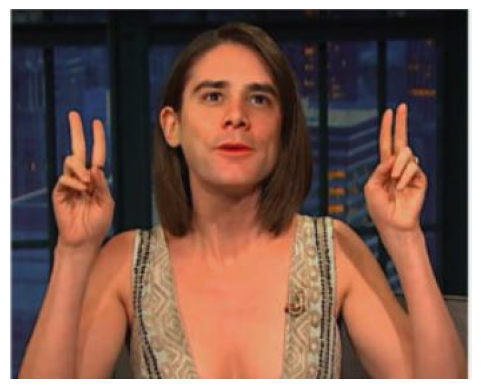

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your image file
image_path = "C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\deepfake_1.jpg"

# Load the image
image = mpimg.imread(image_path)

# Plot the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [45]:
# Normalize the features using the statistics computed earlier
normalized_features = np.zeros_like(psd1D_org_0_mean[:256])
epsilon = 1e-8  # Small epsilon value to avoid division by zero
for i in range(len(normalized_features)):
    normalized_features[i] = (extract_features(image)[i] - psd1D_org_0_mean[i]) / (psd1D_org_0_std[i] + epsilon)

In [46]:
# Reshape the features to match the classifier's input shape
reshaped_features = normalized_features.reshape(1, -1)

In [47]:
print(reshaped_features.size)

256


In [48]:
expected_features=722
padded_x = np.pad(reshaped_features, (0, expected_features - reshaped_features.size), mode='constant')
reshaped_x = np.reshape(padded_x, (expected_features, -1))

In [49]:
svm_prediction = svclassifier.predict(padded_x)

In [50]:
print(svm_prediction[0])

0.0


In [51]:
Lr_prediction=logreg.predict(padded_x)

In [52]:
print(Lr_prediction[0])

0.0


## Fill the csv file with the results of LR and SVM trained at high resolution

In [56]:
import numpy as np 
import os
import shutil
import glob
import csv
import pandas as pd


In [58]:
data=pd.read_csv("C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\Mesonet_filled.csv")

In [59]:
data.head()

,Unnamed: 0.1,Unnamed: 0,Image,Xception_output,Mesonet_output,LR_output,SVM_output,Grounded_truth
0,0,0,0.jpg,1.0,1.0,NaN,NaN,0
1,1,1,000001.jpg,1.0,0.0,NaN,NaN,1
2,2,2,000002.jpg,0.0,0.0,NaN,NaN,1
3,3,3,000003.jpg,1.0,1.0,NaN,NaN,1
4,4,4,000004.jpg,1.0,0.0,NaN,NaN,1


In [60]:
from tqdm import tqdm

In [70]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Image', 'Xception_output',
       'Mesonet_output', 'LR_output', 'SVM_output', 'Grounded_truth'],
      dtype='object')

In [84]:

path_to_data = "C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\deepfakes_image_test"
# now for each image into that folder
images_path = glob.glob(os.path.join(path_to_data, '*.jpg'))
i = 0
expected_features = 722

for x in tqdm(images_path):
    image = mpimg.imread(x)
    normalized_features = np.zeros_like(psd1D_org_0_mean[:256])
    epsilon = 1e-8  # Small epsilon value to avoid division by zero
    
    for j in range(len(normalized_features)):
        normalized_features[j] = (extract_features(image)[j] - psd1D_org_0_mean[j]) / (psd1D_org_0_std[j] + epsilon)
    
    reshaped_features = normalized_features.reshape(1, -1)
    padded_x = np.pad(reshaped_features, (0, expected_features - reshaped_features.size), mode='constant')
    reshaped_x = np.reshape(padded_x, (expected_features, -1))
    
    svm_prediction = svclassifier.predict(padded_x)
    print('result', svm_prediction[0])
    result = svm_prediction[0]
    
    if result == 0:
        data.loc[i, 'SVM_output'] = 0
    else:
        data.loc[i, 'SVM_output'] = 1
        
    i += 1

  0%|          | 1/425 [00:00<00:51,  8.22it/s]

result 0.0


  0%|          | 2/425 [00:00<01:24,  4.99it/s]

result 0.0


  1%|          | 3/425 [00:00<01:34,  4.47it/s]

result 0.0


  1%|          | 4/425 [00:00<01:43,  4.06it/s]

result 0.0


  1%|          | 5/425 [00:01<01:49,  3.85it/s]

result 0.0


  1%|▏         | 6/425 [00:01<01:48,  3.85it/s]

result 0.0


  2%|▏         | 7/425 [00:01<01:46,  3.91it/s]

result 0.0


  2%|▏         | 8/425 [00:01<01:46,  3.93it/s]

result 0.0


  2%|▏         | 9/425 [00:02<01:46,  3.92it/s]

result 0.0


  2%|▏         | 10/425 [00:02<01:46,  3.91it/s]

result 0.0


  3%|▎         | 11/425 [00:02<01:49,  3.78it/s]

result 0.0


  3%|▎         | 12/425 [00:03<01:50,  3.73it/s]

result 0.0


  3%|▎         | 13/425 [00:03<01:48,  3.80it/s]

result 1.0


  3%|▎         | 14/425 [00:03<01:47,  3.84it/s]

result 1.0


  4%|▎         | 15/425 [00:03<01:46,  3.84it/s]

result 0.0


  4%|▍         | 16/425 [00:04<01:44,  3.90it/s]

result 0.0


  4%|▍         | 17/425 [00:04<01:43,  3.94it/s]

result 0.0


  4%|▍         | 18/425 [00:04<01:42,  3.98it/s]

result 0.0


  4%|▍         | 19/425 [00:04<01:41,  4.01it/s]

result 0.0


  5%|▍         | 20/425 [00:05<01:40,  4.03it/s]

result 0.0


  5%|▍         | 21/425 [00:05<01:40,  4.03it/s]

result 1.0


  5%|▌         | 22/425 [00:05<01:39,  4.05it/s]

result 0.0


  5%|▌         | 23/425 [00:05<01:39,  4.04it/s]

result 0.0


  6%|▌         | 24/425 [00:06<01:40,  3.97it/s]

result 0.0


  6%|▌         | 25/425 [00:06<01:41,  3.92it/s]

result 0.0


  6%|▌         | 26/425 [00:06<01:40,  3.96it/s]

result 0.0


  6%|▋         | 27/425 [00:06<01:40,  3.95it/s]

result 0.0


  7%|▋         | 28/425 [00:07<01:40,  3.95it/s]

result 0.0


  7%|▋         | 29/425 [00:07<01:39,  3.96it/s]

result 0.0


  7%|▋         | 31/425 [00:07<01:23,  4.71it/s]

result 0.0
result 0.0


  8%|▊         | 33/425 [00:07<01:05,  5.99it/s]

result 0.0
result 0.0


  8%|▊         | 34/425 [00:08<02:05,  3.12it/s]

result 0.0


  8%|▊         | 35/425 [00:09<02:50,  2.28it/s]

result 0.0


  8%|▊         | 36/425 [00:10<03:24,  1.90it/s]

result 0.0


  9%|▊         | 37/425 [00:10<04:08,  1.56it/s]

result 0.0


  9%|▉         | 38/425 [00:11<04:21,  1.48it/s]

result 0.0


  9%|▉         | 39/425 [00:12<04:29,  1.43it/s]

result 0.0


  9%|▉         | 40/425 [00:13<04:51,  1.32it/s]

result 0.0


 10%|▉         | 41/425 [00:14<04:45,  1.34it/s]

result 0.0


 10%|▉         | 42/425 [00:15<05:08,  1.24it/s]

result 0.0


 10%|█         | 43/425 [00:15<05:16,  1.21it/s]

result 0.0


 10%|█         | 44/425 [00:16<04:44,  1.34it/s]

result 0.0


 11%|█         | 45/425 [00:17<05:17,  1.20it/s]

result 0.0


 11%|█         | 46/425 [00:18<05:21,  1.18it/s]

result 0.0


 11%|█         | 47/425 [00:19<05:10,  1.22it/s]

result 0.0


 11%|█▏        | 48/425 [00:19<05:13,  1.20it/s]

result 0.0


 12%|█▏        | 49/425 [00:20<05:06,  1.23it/s]

result 0.0


 12%|█▏        | 50/425 [00:21<04:57,  1.26it/s]

result 0.0


 12%|█▏        | 51/425 [00:22<05:45,  1.08it/s]

result 0.0


 12%|█▏        | 52/425 [00:23<06:09,  1.01it/s]

result 0.0


 12%|█▏        | 53/425 [00:24<06:05,  1.02it/s]

result 0.0


 13%|█▎        | 54/425 [00:25<05:45,  1.08it/s]

result 0.0


 13%|█▎        | 55/425 [00:26<05:47,  1.07it/s]

result 0.0


 13%|█▎        | 56/425 [00:27<05:38,  1.09it/s]

result 0.0


 13%|█▎        | 57/425 [00:28<05:18,  1.16it/s]

result 0.0


 14%|█▎        | 58/425 [00:29<05:15,  1.16it/s]

result 0.0


 14%|█▍        | 59/425 [00:29<05:07,  1.19it/s]

result 0.0


 14%|█▍        | 60/425 [00:30<05:01,  1.21it/s]

result 0.0


 14%|█▍        | 61/425 [00:31<05:09,  1.18it/s]

result 0.0


 15%|█▍        | 62/425 [00:32<05:23,  1.12it/s]

result 0.0


 15%|█▍        | 63/425 [00:33<05:11,  1.16it/s]

result 0.0


 15%|█▌        | 64/425 [00:34<04:59,  1.20it/s]

result 0.0


 15%|█▌        | 65/425 [00:34<04:51,  1.23it/s]

result 0.0


 16%|█▌        | 66/425 [00:35<05:06,  1.17it/s]

result 0.0


 16%|█▌        | 67/425 [00:36<04:50,  1.23it/s]

result 0.0


 16%|█▌        | 68/425 [00:37<04:29,  1.32it/s]

result 0.0


 16%|█▌        | 69/425 [00:37<04:35,  1.29it/s]

result 0.0


 16%|█▋        | 70/425 [00:38<04:26,  1.33it/s]

result 0.0


 17%|█▋        | 71/425 [00:39<04:20,  1.36it/s]

result 0.0


 17%|█▋        | 72/425 [00:40<04:42,  1.25it/s]

result 0.0


 17%|█▋        | 73/425 [00:41<04:39,  1.26it/s]

result 0.0


 17%|█▋        | 74/425 [00:41<04:39,  1.25it/s]

result 0.0


 18%|█▊        | 75/425 [00:42<04:39,  1.25it/s]

result 0.0


 18%|█▊        | 76/425 [00:43<04:16,  1.36it/s]

result 0.0


 18%|█▊        | 78/425 [00:43<02:58,  1.94it/s]

result 0.0
result 0.0


 19%|█▉        | 80/425 [00:44<01:47,  3.22it/s]

result 0.0
result 0.0


 19%|█▉        | 82/425 [00:44<01:12,  4.76it/s]

result 0.0
result 0.0


 20%|█▉        | 84/425 [00:44<00:54,  6.22it/s]

result 0.0
result 0.0


 20%|██        | 86/425 [00:44<00:46,  7.21it/s]

result 0.0
result 0.0


 21%|██        | 88/425 [00:45<00:42,  7.85it/s]

result 0.0
result 0.0


 21%|██        | 90/425 [00:45<00:40,  8.21it/s]

result 0.0
result 0.0


 22%|██▏       | 92/425 [00:45<00:39,  8.45it/s]

result 0.0
result 0.0


 22%|██▏       | 94/425 [00:45<00:38,  8.50it/s]

result 0.0
result 0.0


 23%|██▎       | 96/425 [00:46<00:38,  8.56it/s]

result 0.0
result 0.0


 23%|██▎       | 98/425 [00:46<00:37,  8.61it/s]

result 0.0
result 0.0


 24%|██▎       | 100/425 [00:46<00:37,  8.71it/s]

result 0.0
result 0.0


 24%|██▍       | 102/425 [00:46<00:37,  8.71it/s]

result 0.0
result 0.0
result 0.0


 25%|██▍       | 105/425 [00:47<00:35,  9.03it/s]

result 0.0
result 0.0


 25%|██▌       | 107/425 [00:47<00:34,  9.23it/s]

result 0.0
result 0.0
result 0.0


 26%|██▌       | 111/425 [00:47<00:31,  9.86it/s]

result 0.0
result 0.0
result 0.0


 27%|██▋       | 113/425 [00:47<00:29, 10.43it/s]

result 0.0
result 0.0


 27%|██▋       | 115/425 [00:48<00:29, 10.45it/s]

result 0.0
result 0.0
result 0.0


 28%|██▊       | 119/425 [00:48<00:29, 10.45it/s]

result 0.0
result 0.0
result 0.0


 28%|██▊       | 121/425 [00:48<00:28, 10.58it/s]

result 0.0
result 0.0
result 0.0


 29%|██▉       | 125/425 [00:48<00:28, 10.64it/s]

result 0.0
result 0.0
result 0.0


 30%|██▉       | 127/425 [00:49<00:28, 10.59it/s]

result 0.0
result 0.0
result 0.0


 30%|███       | 129/425 [00:49<00:27, 10.66it/s]

result 0.0
result 0.0


 31%|███       | 131/425 [00:49<00:38,  7.54it/s]

result 0.0


 31%|███       | 132/425 [00:50<00:45,  6.44it/s]

result 0.0


 31%|███▏      | 133/425 [00:50<00:56,  5.14it/s]

result 0.0


 32%|███▏      | 134/425 [00:50<01:07,  4.32it/s]

result 0.0


 32%|███▏      | 135/425 [00:51<01:14,  3.90it/s]

result 0.0


 32%|███▏      | 136/425 [00:51<01:19,  3.65it/s]

result 0.0


 32%|███▏      | 137/425 [00:51<01:23,  3.47it/s]

result 0.0


 32%|███▏      | 138/425 [00:52<01:25,  3.34it/s]

result 0.0


 33%|███▎      | 139/425 [00:52<01:30,  3.16it/s]

result 0.0


 33%|███▎      | 140/425 [00:52<01:32,  3.08it/s]

result 0.0


 33%|███▎      | 141/425 [00:53<01:31,  3.11it/s]

result 0.0


 33%|███▎      | 142/425 [00:53<01:32,  3.08it/s]

result 0.0


 34%|███▎      | 143/425 [00:53<01:32,  3.06it/s]

result 0.0


 34%|███▍      | 144/425 [00:54<01:32,  3.05it/s]

result 0.0


 34%|███▍      | 145/425 [00:54<01:33,  3.00it/s]

result 0.0


 34%|███▍      | 146/425 [00:54<01:33,  2.98it/s]

result 0.0


 35%|███▍      | 148/425 [00:55<01:14,  3.72it/s]

result 0.0
result 0.0


 35%|███▌      | 149/425 [00:55<01:19,  3.46it/s]

result 0.0


 36%|███▌      | 152/425 [00:56<00:53,  5.11it/s]

result 0.0
result 0.0
result 0.0
result 0.0


 37%|███▋      | 156/425 [00:56<00:42,  6.27it/s]

result 0.0
result 0.0
result 0.0


 37%|███▋      | 158/425 [00:56<00:34,  7.74it/s]

result 0.0
result 0.0
result 0.0


 38%|███▊      | 162/425 [00:57<00:34,  7.61it/s]

result 0.0
result 0.0
result 0.0


 39%|███▊      | 164/425 [00:57<00:30,  8.58it/s]

result 0.0
result 0.0
result 0.0


 39%|███▉      | 166/425 [00:57<00:27,  9.28it/s]

result 0.0


 40%|███▉      | 168/425 [00:58<00:35,  7.21it/s]

result 0.0
result 0.0
result 0.0


 40%|████      | 172/425 [00:58<00:27,  9.13it/s]

result 0.0
result 0.0
result 0.0
result 0.0


 41%|████      | 174/425 [00:59<00:47,  5.26it/s]

result 0.0


 41%|████      | 175/425 [00:59<00:54,  4.56it/s]

result 0.0


 41%|████▏     | 176/425 [00:59<01:02,  4.01it/s]

result 0.0


 42%|████▏     | 177/425 [01:00<01:05,  3.81it/s]

result 0.0


 42%|████▏     | 178/425 [01:00<01:09,  3.57it/s]

result 0.0


 42%|████▏     | 179/425 [01:00<01:12,  3.40it/s]

result 0.0


 43%|████▎     | 181/425 [01:01<00:59,  4.11it/s]

result 0.0
result 0.0


 43%|████▎     | 182/425 [01:01<01:12,  3.37it/s]

result 1.0


 43%|████▎     | 183/425 [01:02<01:42,  2.36it/s]

result 1.0


 43%|████▎     | 184/425 [01:03<02:06,  1.91it/s]

result 1.0


 44%|████▎     | 185/425 [01:03<02:05,  1.91it/s]

result 1.0


 44%|████▍     | 188/425 [01:04<01:25,  2.76it/s]

result 1.0
result 0.0
result 0.0


 45%|████▍     | 190/425 [01:04<00:58,  4.02it/s]

result 0.0
result 0.0
result 0.0


 46%|████▌     | 194/425 [01:05<00:44,  5.14it/s]

result 1.0
result 0.0
result 0.0


 46%|████▌     | 196/425 [01:05<00:35,  6.37it/s]

result 0.0
result 0.0
result 0.0


 47%|████▋     | 200/425 [01:05<00:24,  9.01it/s]

result 0.0
result 0.0
result 0.0
result 0.0


 48%|████▊     | 204/425 [01:06<00:19, 11.22it/s]

result 0.0
result 0.0
result 0.0
result 0.0


 48%|████▊     | 206/425 [01:06<00:18, 11.88it/s]

result 0.0
result 0.0


 49%|████▉     | 210/425 [01:07<00:25,  8.28it/s]

result 1.0
result 0.0
result 0.0


 50%|████▉     | 212/425 [01:07<00:22,  9.38it/s]

result 0.0
result 0.0
result 0.0


 50%|█████     | 214/425 [01:07<00:20, 10.18it/s]

result 0.0
result 0.0


 51%|█████▏    | 218/425 [01:08<00:25,  8.02it/s]

result 1.0
result 0.0
result 0.0


 52%|█████▏    | 220/425 [01:08<00:22,  9.06it/s]

result 0.0
result 0.0
result 0.0


 52%|█████▏    | 222/425 [01:08<00:37,  5.47it/s]

result 0.0


 52%|█████▏    | 223/425 [01:09<00:51,  3.90it/s]

result 0.0


 53%|█████▎    | 224/425 [01:10<01:01,  3.27it/s]

result 1.0


 53%|█████▎    | 225/425 [01:10<01:09,  2.88it/s]

result 1.0


 53%|█████▎    | 226/425 [01:10<01:12,  2.74it/s]

result 1.0


 53%|█████▎    | 227/425 [01:11<01:20,  2.45it/s]

result 1.0


 54%|█████▎    | 228/425 [01:12<01:29,  2.20it/s]

result 1.0


 54%|█████▍    | 229/425 [01:12<01:35,  2.05it/s]

result 1.0


 54%|█████▍    | 230/425 [01:13<01:43,  1.89it/s]

result 1.0


 55%|█████▍    | 232/425 [01:14<01:25,  2.25it/s]

result 1.0
result 0.0


 55%|█████▍    | 233/425 [01:14<01:25,  2.23it/s]

result 1.0


 55%|█████▌    | 234/425 [01:14<01:24,  2.26it/s]

result 1.0


 55%|█████▌    | 235/425 [01:15<01:27,  2.18it/s]

result 0.0


 56%|█████▌    | 236/425 [01:16<01:31,  2.07it/s]

result 1.0


 56%|█████▌    | 237/425 [01:16<01:32,  2.03it/s]

result 1.0


 56%|█████▌    | 238/425 [01:17<01:36,  1.94it/s]

result 1.0


 56%|█████▌    | 239/425 [01:17<01:38,  1.89it/s]

result 1.0


 56%|█████▋    | 240/425 [01:18<01:43,  1.79it/s]

result 1.0


 57%|█████▋    | 241/425 [01:18<01:36,  1.90it/s]

result 1.0


 57%|█████▋    | 242/425 [01:19<01:28,  2.07it/s]

result 0.0


 57%|█████▋    | 243/425 [01:19<01:19,  2.30it/s]

result 1.0


 57%|█████▋    | 244/425 [01:19<01:22,  2.21it/s]

result 0.0


 58%|█████▊    | 245/425 [01:20<01:25,  2.11it/s]

result 0.0


 58%|█████▊    | 246/425 [01:21<01:30,  1.97it/s]

result 0.0


 58%|█████▊    | 247/425 [01:21<01:40,  1.77it/s]

result 0.0


 58%|█████▊    | 248/425 [01:22<02:00,  1.46it/s]

result 1.0


 59%|█████▊    | 249/425 [01:23<01:50,  1.60it/s]

result 1.0


 59%|█████▉    | 250/425 [01:24<02:26,  1.20it/s]

result 1.0


 59%|█████▉    | 251/425 [01:25<02:43,  1.06it/s]

result 0.0


 59%|█████▉    | 252/425 [01:26<02:26,  1.18it/s]

result 1.0


 60%|█████▉    | 253/425 [01:27<02:38,  1.08it/s]

result 0.0


 60%|█████▉    | 254/425 [01:27<02:10,  1.31it/s]

result 1.0


 60%|██████    | 255/425 [01:28<01:51,  1.52it/s]

result 1.0


 60%|██████    | 256/425 [01:28<01:39,  1.70it/s]

result 1.0


 60%|██████    | 257/425 [01:29<01:31,  1.83it/s]

result 1.0


 61%|██████    | 258/425 [01:29<01:16,  2.17it/s]

result 1.0


 61%|██████    | 259/425 [01:29<01:16,  2.18it/s]

result 1.0


 61%|██████    | 260/425 [01:30<01:41,  1.63it/s]

result 1.0


 61%|██████▏   | 261/425 [01:31<01:47,  1.52it/s]

result 1.0


 62%|██████▏   | 262/425 [01:32<01:54,  1.42it/s]

result 1.0


 62%|██████▏   | 263/425 [01:33<02:00,  1.35it/s]

result 1.0


 62%|██████▏   | 264/425 [01:34<02:09,  1.25it/s]

result 1.0


 62%|██████▏   | 265/425 [01:35<02:12,  1.21it/s]

result 1.0


 63%|██████▎   | 266/425 [01:35<02:00,  1.32it/s]

result 1.0


 63%|██████▎   | 267/425 [01:36<02:09,  1.22it/s]

result 1.0


 63%|██████▎   | 268/425 [01:37<01:54,  1.37it/s]

result 1.0


 63%|██████▎   | 269/425 [01:37<01:42,  1.52it/s]

result 1.0


 64%|██████▎   | 270/425 [01:38<01:34,  1.65it/s]

result 1.0


 64%|██████▍   | 272/425 [01:38<01:08,  2.22it/s]

result 1.0
result 0.0


 64%|██████▍   | 274/425 [01:38<00:42,  3.54it/s]

result 0.0
result 0.0


 65%|██████▍   | 276/425 [01:39<00:29,  5.12it/s]

result 0.0
result 0.0


 65%|██████▌   | 278/425 [01:39<00:22,  6.56it/s]

result 0.0
result 0.0


 66%|██████▌   | 280/425 [01:39<00:19,  7.58it/s]

result 0.0
result 0.0


 66%|██████▋   | 282/425 [01:39<00:17,  8.21it/s]

result 0.0
result 0.0


 67%|██████▋   | 284/425 [01:40<00:16,  8.58it/s]

result 0.0
result 0.0


 67%|██████▋   | 286/425 [01:40<00:15,  8.77it/s]

result 0.0
result 0.0


 68%|██████▊   | 288/425 [01:40<00:15,  8.78it/s]

result 0.0
result 0.0


 68%|██████▊   | 290/425 [01:40<00:17,  7.67it/s]

result 0.0
result 0.0


 69%|██████▊   | 292/425 [01:41<00:19,  6.66it/s]

result 0.0
result 0.0


 69%|██████▉   | 294/425 [01:41<00:21,  6.06it/s]

result 0.0
result 0.0


 69%|██████▉   | 295/425 [01:41<00:22,  5.75it/s]

result 0.0


 70%|██████▉   | 296/425 [01:41<00:24,  5.18it/s]

result 0.0


 70%|██████▉   | 297/425 [01:42<00:34,  3.75it/s]

result 0.0


 70%|███████   | 298/425 [01:42<00:40,  3.10it/s]

result 0.0


 70%|███████   | 299/425 [01:43<00:46,  2.72it/s]

result 0.0


 71%|███████   | 300/425 [01:43<00:50,  2.46it/s]

result 0.0


 71%|███████   | 301/425 [01:44<00:53,  2.30it/s]

result 0.0


 71%|███████   | 302/425 [01:44<00:55,  2.21it/s]

result 0.0


 71%|███████▏  | 303/425 [01:45<00:55,  2.20it/s]

result 0.0


 72%|███████▏  | 304/425 [01:45<00:55,  2.18it/s]

result 0.0


 72%|███████▏  | 305/425 [01:46<00:56,  2.14it/s]

result 0.0


 72%|███████▏  | 306/425 [01:46<00:55,  2.16it/s]

result 0.0


 72%|███████▏  | 307/425 [01:47<00:53,  2.23it/s]

result 0.0


 72%|███████▏  | 308/425 [01:47<00:52,  2.25it/s]

result 0.0


 73%|███████▎  | 309/425 [01:48<00:53,  2.18it/s]

result 0.0


 73%|███████▎  | 310/425 [01:48<00:54,  2.11it/s]

result 0.0


 73%|███████▎  | 311/425 [01:49<00:55,  2.04it/s]

result 0.0


 73%|███████▎  | 312/425 [01:49<00:56,  2.01it/s]

result 0.0


 74%|███████▎  | 313/425 [01:50<00:54,  2.04it/s]

result 0.0


 74%|███████▍  | 314/425 [01:50<00:54,  2.05it/s]

result 0.0


 74%|███████▍  | 315/425 [01:51<00:54,  2.02it/s]

result 0.0


 74%|███████▍  | 316/425 [01:51<00:53,  2.03it/s]

result 0.0


 75%|███████▍  | 317/425 [01:52<00:53,  2.02it/s]

result 0.0


 75%|███████▍  | 318/425 [01:52<00:52,  2.04it/s]

result 0.0


 75%|███████▌  | 319/425 [01:53<00:53,  2.00it/s]

result 0.0


 75%|███████▌  | 320/425 [01:53<00:52,  2.00it/s]

result 0.0


 76%|███████▌  | 321/425 [01:54<00:51,  2.02it/s]

result 0.0


 76%|███████▌  | 322/425 [01:54<00:50,  2.03it/s]

result 0.0


 76%|███████▌  | 323/425 [01:54<00:47,  2.16it/s]

result 0.0


 76%|███████▌  | 324/425 [01:55<00:45,  2.23it/s]

result 0.0


 76%|███████▋  | 325/425 [01:55<00:45,  2.19it/s]

result 0.0


 77%|███████▋  | 326/425 [01:56<00:44,  2.22it/s]

result 0.0


 77%|███████▋  | 327/425 [01:56<00:43,  2.24it/s]

result 0.0


 77%|███████▋  | 328/425 [01:57<00:42,  2.29it/s]

result 0.0


 77%|███████▋  | 329/425 [01:57<00:41,  2.30it/s]

result 0.0


 78%|███████▊  | 330/425 [01:57<00:40,  2.34it/s]

result 0.0


 78%|███████▊  | 331/425 [01:58<00:40,  2.32it/s]

result 0.0


 78%|███████▊  | 332/425 [01:58<00:39,  2.36it/s]

result 0.0


 78%|███████▊  | 333/425 [01:59<00:50,  1.81it/s]

result 0.0


 79%|███████▊  | 334/425 [01:59<00:41,  2.17it/s]

result 0.0


 79%|███████▉  | 335/425 [02:00<00:35,  2.54it/s]

result 0.0


 79%|███████▉  | 336/425 [02:00<00:43,  2.05it/s]

result 0.0


 79%|███████▉  | 337/425 [02:02<01:01,  1.43it/s]

result 0.0


 80%|███████▉  | 338/425 [02:02<01:00,  1.43it/s]

result 0.0


 80%|███████▉  | 339/425 [02:03<00:59,  1.46it/s]

result 0.0


 80%|████████  | 340/425 [02:03<00:56,  1.50it/s]

result 0.0


 80%|████████  | 341/425 [02:04<00:55,  1.51it/s]

result 0.0


 80%|████████  | 342/425 [02:05<00:53,  1.54it/s]

result 0.0


 81%|████████  | 343/425 [02:05<00:52,  1.56it/s]

result 0.0


 81%|████████  | 344/425 [02:06<00:51,  1.57it/s]

result 0.0


 81%|████████  | 345/425 [02:07<00:50,  1.57it/s]

result 0.0


 81%|████████▏ | 346/425 [02:07<00:52,  1.50it/s]

result 0.0


 82%|████████▏ | 347/425 [02:08<00:49,  1.58it/s]

result 0.0


 82%|████████▏ | 348/425 [02:08<00:45,  1.70it/s]

result 0.0


 82%|████████▏ | 349/425 [02:09<00:47,  1.61it/s]

result 0.0


 82%|████████▏ | 350/425 [02:10<00:49,  1.51it/s]

result 0.0


 83%|████████▎ | 351/425 [02:10<00:45,  1.63it/s]

result 0.0


 83%|████████▎ | 352/425 [02:11<00:42,  1.70it/s]

result 0.0


 83%|████████▎ | 353/425 [02:11<00:41,  1.74it/s]

result 0.0


 83%|████████▎ | 354/425 [02:12<00:39,  1.78it/s]

result 0.0


 84%|████████▎ | 355/425 [02:13<00:49,  1.42it/s]

result 0.0


 84%|████████▍ | 356/425 [02:14<00:58,  1.18it/s]

result 0.0


 84%|████████▍ | 357/425 [02:15<00:55,  1.23it/s]

result 0.0


 84%|████████▍ | 358/425 [02:16<01:01,  1.09it/s]

result 0.0


 84%|████████▍ | 359/425 [02:17<01:04,  1.03it/s]

result 0.0


 85%|████████▍ | 360/425 [02:18<01:06,  1.02s/it]

result 0.0


 85%|████████▍ | 361/425 [02:20<01:09,  1.08s/it]

result 0.0


 85%|████████▌ | 362/425 [02:20<01:02,  1.01it/s]

result 0.0


 85%|████████▌ | 363/425 [02:21<00:47,  1.31it/s]

result 0.0


 86%|████████▌ | 364/425 [02:21<00:36,  1.67it/s]

result 0.0


 86%|████████▌ | 366/425 [02:21<00:23,  2.50it/s]

result 0.0
result 0.0


 87%|████████▋ | 368/425 [02:21<00:14,  3.96it/s]

result 0.0
result 0.0


 87%|████████▋ | 370/425 [02:22<00:09,  5.54it/s]

result 0.0
result 0.0


 87%|████████▋ | 371/425 [02:22<00:11,  4.52it/s]

result 1.0


 88%|████████▊ | 372/425 [02:22<00:13,  4.02it/s]

result 1.0


 88%|████████▊ | 373/425 [02:23<00:14,  3.70it/s]

result 1.0


 88%|████████▊ | 374/425 [02:23<00:14,  3.51it/s]

result 1.0


 88%|████████▊ | 375/425 [02:23<00:14,  3.36it/s]

result 1.0


 88%|████████▊ | 376/425 [02:24<00:15,  3.25it/s]

result 0.0


 89%|████████▊ | 377/425 [02:24<00:15,  3.15it/s]

result 0.0


 89%|████████▉ | 378/425 [02:24<00:15,  3.11it/s]

result 0.0


 89%|████████▉ | 379/425 [02:25<00:15,  3.06it/s]

result 0.0


 89%|████████▉ | 380/425 [02:25<00:14,  3.08it/s]

result 1.0


 90%|████████▉ | 381/425 [02:25<00:14,  3.12it/s]

result 1.0


 90%|████████▉ | 382/425 [02:26<00:13,  3.12it/s]

result 0.0


 90%|█████████ | 383/425 [02:26<00:13,  3.13it/s]

result 1.0


 90%|█████████ | 384/425 [02:26<00:13,  3.09it/s]

result 1.0


 91%|█████████ | 385/425 [02:26<00:12,  3.12it/s]

result 0.0


 91%|█████████ | 386/425 [02:27<00:12,  3.15it/s]

result 1.0


 91%|█████████ | 387/425 [02:27<00:12,  3.16it/s]

result 1.0


 91%|█████████▏| 388/425 [02:27<00:11,  3.19it/s]

result 1.0


 92%|█████████▏| 389/425 [02:28<00:11,  3.19it/s]

result 0.0


 92%|█████████▏| 390/425 [02:28<00:10,  3.20it/s]

result 1.0


 92%|█████████▏| 391/425 [02:28<00:10,  3.20it/s]

result 0.0


 92%|█████████▏| 392/425 [02:29<00:10,  3.21it/s]

result 0.0


 92%|█████████▏| 393/425 [02:29<00:09,  3.22it/s]

result 1.0


 93%|█████████▎| 394/425 [02:29<00:09,  3.22it/s]

result 1.0


 93%|█████████▎| 395/425 [02:30<00:09,  3.16it/s]

result 1.0


 93%|█████████▎| 396/425 [02:30<00:09,  3.17it/s]

result 1.0


 93%|█████████▎| 397/425 [02:30<00:08,  3.19it/s]

result 1.0


 94%|█████████▎| 398/425 [02:31<00:08,  3.20it/s]

result 0.0


 94%|█████████▍| 399/425 [02:31<00:08,  3.20it/s]

result 1.0


 94%|█████████▍| 400/425 [02:31<00:07,  3.20it/s]

result 0.0


 94%|█████████▍| 401/425 [02:31<00:07,  3.20it/s]

result 1.0


 95%|█████████▍| 402/425 [02:32<00:07,  3.19it/s]

result 1.0


 95%|█████████▍| 403/425 [02:32<00:06,  3.21it/s]

result 1.0


 95%|█████████▌| 404/425 [02:32<00:06,  3.21it/s]

result 1.0


 95%|█████████▌| 405/425 [02:33<00:06,  3.22it/s]

result 1.0


 96%|█████████▌| 406/425 [02:33<00:05,  3.22it/s]

result 1.0


 96%|█████████▌| 407/425 [02:33<00:05,  3.23it/s]

result 1.0


 96%|█████████▌| 408/425 [02:34<00:05,  3.22it/s]

result 0.0


 96%|█████████▌| 409/425 [02:34<00:04,  3.22it/s]

result 0.0


 96%|█████████▋| 410/425 [02:34<00:04,  3.23it/s]

result 0.0


 97%|█████████▋| 411/425 [02:35<00:04,  3.18it/s]

result 0.0


 97%|█████████▋| 412/425 [02:35<00:04,  3.17it/s]

result 1.0


 97%|█████████▋| 413/425 [02:35<00:03,  3.18it/s]

result 1.0


 97%|█████████▋| 414/425 [02:36<00:03,  3.20it/s]

result 0.0


 98%|█████████▊| 415/425 [02:36<00:03,  3.19it/s]

result 1.0


 98%|█████████▊| 416/425 [02:36<00:02,  3.21it/s]

result 1.0


 98%|█████████▊| 417/425 [02:36<00:02,  3.22it/s]

result 1.0


 98%|█████████▊| 418/425 [02:37<00:02,  3.23it/s]

result 1.0


 99%|█████████▊| 419/425 [02:37<00:01,  3.22it/s]

result 1.0


 99%|█████████▉| 420/425 [02:37<00:01,  3.19it/s]

result 1.0


 99%|█████████▉| 421/425 [02:38<00:01,  3.17it/s]

result 1.0


 99%|█████████▉| 422/425 [02:38<00:00,  3.16it/s]

result 0.0


100%|█████████▉| 423/425 [02:38<00:00,  3.17it/s]

result 0.0


100%|█████████▉| 424/425 [02:39<00:00,  3.13it/s]

result 1.0


100%|██████████| 425/425 [02:39<00:00,  2.66it/s]

result 1.0


In [85]:
data.head()

,Unnamed: 0.1,Unnamed: 0,Image,Xception_output,Mesonet_output,LR_output,SVM_output,Grounded_truth
0,0,0,0.jpg,1.0,1.0,NaN,0.0,0
1,1,1,000001.jpg,1.0,0.0,NaN,0.0,1
2,2,2,000002.jpg,0.0,0.0,NaN,0.0,1
3,3,3,000003.jpg,1.0,1.0,NaN,0.0,1
4,4,4,000004.jpg,1.0,0.0,NaN,0.0,1


In [86]:
data.loc[424, 'SVM_output'] 

1.0

In [87]:
data.to_csv("SVM_filled.csv")

In [88]:
df=pd.read_csv("SVM_filled.csv")

  0%|          | 1/425 [00:00<00:51,  8.28it/s]

result 1.0


  0%|          | 2/425 [00:00<01:21,  5.21it/s]

result 0.0


  1%|          | 3/425 [00:00<01:30,  4.65it/s]

result 1.0


  1%|          | 4/425 [00:00<01:34,  4.43it/s]

result 1.0


  1%|          | 5/425 [00:01<01:38,  4.25it/s]

result 0.0


  1%|▏         | 6/425 [00:01<01:41,  4.14it/s]

result 1.0


  2%|▏         | 7/425 [00:01<01:42,  4.06it/s]

result 0.0


  2%|▏         | 8/425 [00:01<01:43,  4.02it/s]

result 0.0


  2%|▏         | 9/425 [00:02<01:44,  3.99it/s]

result 0.0


  2%|▏         | 10/425 [00:02<01:45,  3.93it/s]

result 0.0


  3%|▎         | 11/425 [00:02<01:46,  3.88it/s]

result 0.0


  3%|▎         | 12/425 [00:02<01:45,  3.91it/s]

result 0.0


  3%|▎         | 13/425 [00:03<01:45,  3.92it/s]

result 1.0


  3%|▎         | 14/425 [00:03<01:44,  3.95it/s]

result 1.0


  4%|▎         | 15/425 [00:03<01:46,  3.86it/s]

result 0.0


  4%|▍         | 16/425 [00:03<01:47,  3.79it/s]

result 1.0


  4%|▍         | 17/425 [00:04<01:46,  3.82it/s]

result 0.0


  4%|▍         | 18/425 [00:04<01:44,  3.90it/s]

result 0.0


  4%|▍         | 19/425 [00:04<01:43,  3.92it/s]

result 0.0


  5%|▍         | 20/425 [00:04<01:42,  3.94it/s]

result 1.0


  5%|▍         | 21/425 [00:05<01:43,  3.91it/s]

result 0.0


  5%|▌         | 22/425 [00:05<01:44,  3.87it/s]

result 1.0


  5%|▌         | 23/425 [00:05<01:42,  3.91it/s]

result 0.0


  6%|▌         | 24/425 [00:05<01:41,  3.96it/s]

result 0.0


  6%|▌         | 25/425 [00:06<01:40,  4.00it/s]

result 0.0


  6%|▌         | 26/425 [00:06<01:39,  4.03it/s]

result 1.0


  6%|▋         | 27/425 [00:06<01:38,  4.04it/s]

result 0.0


  7%|▋         | 28/425 [00:06<01:37,  4.06it/s]

result 0.0


  7%|▋         | 29/425 [00:07<01:38,  4.03it/s]

result 1.0


  7%|▋         | 31/425 [00:07<01:21,  4.83it/s]

result 1.0
result 1.0


  8%|▊         | 33/425 [00:07<01:02,  6.27it/s]

result 1.0
result 1.0


  8%|▊         | 34/425 [00:08<01:59,  3.27it/s]

result 0.0


  8%|▊         | 35/425 [00:09<02:46,  2.34it/s]

result 0.0


  8%|▊         | 36/425 [00:09<03:22,  1.92it/s]

result 0.0


  9%|▊         | 37/425 [00:10<04:05,  1.58it/s]

result 0.0


  9%|▉         | 38/425 [00:11<04:12,  1.53it/s]

result 0.0


  9%|▉         | 39/425 [00:12<04:24,  1.46it/s]

result 0.0


  9%|▉         | 40/425 [00:13<04:48,  1.34it/s]

result 0.0


 10%|▉         | 41/425 [00:13<04:43,  1.36it/s]

result 0.0


 10%|▉         | 42/425 [00:14<05:08,  1.24it/s]

result 0.0


 10%|█         | 43/425 [00:15<05:11,  1.23it/s]

result 0.0


 10%|█         | 44/425 [00:16<04:33,  1.39it/s]

result 0.0


 11%|█         | 45/425 [00:17<05:03,  1.25it/s]

result 0.0


 11%|█         | 46/425 [00:18<05:15,  1.20it/s]

result 0.0


 11%|█         | 47/425 [00:18<05:07,  1.23it/s]

result 0.0


 11%|█▏        | 48/425 [00:19<05:20,  1.18it/s]

result 0.0


 12%|█▏        | 49/425 [00:20<05:13,  1.20it/s]

result 0.0


 12%|█▏        | 50/425 [00:21<05:04,  1.23it/s]

result 0.0


 12%|█▏        | 51/425 [00:22<05:50,  1.07it/s]

result 0.0


 12%|█▏        | 52/425 [00:23<06:13,  1.00s/it]

result 0.0


 12%|█▏        | 53/425 [00:24<06:11,  1.00it/s]

result 0.0


 13%|█▎        | 54/425 [00:25<05:50,  1.06it/s]

result 0.0


 13%|█▎        | 55/425 [00:26<05:48,  1.06it/s]

result 0.0


 13%|█▎        | 56/425 [00:27<05:36,  1.10it/s]

result 0.0


 13%|█▎        | 57/425 [00:28<05:16,  1.16it/s]

result 0.0


 14%|█▎        | 58/425 [00:28<05:14,  1.17it/s]

result 0.0


 14%|█▍        | 59/425 [00:29<05:08,  1.19it/s]

result 0.0


 14%|█▍        | 60/425 [00:30<05:02,  1.20it/s]

result 0.0


 14%|█▍        | 61/425 [00:31<05:04,  1.20it/s]

result 0.0


 15%|█▍        | 62/425 [00:32<05:08,  1.18it/s]

result 0.0


 15%|█▍        | 63/425 [00:32<04:58,  1.21it/s]

result 0.0


 15%|█▌        | 64/425 [00:33<04:52,  1.23it/s]

result 0.0


 15%|█▌        | 65/425 [00:34<04:47,  1.25it/s]

result 0.0


 16%|█▌        | 66/425 [00:35<05:11,  1.15it/s]

result 0.0


 16%|█▌        | 67/425 [00:36<04:57,  1.21it/s]

result 0.0


 16%|█▌        | 68/425 [00:36<04:30,  1.32it/s]

result 0.0


 16%|█▌        | 69/425 [00:37<04:40,  1.27it/s]

result 0.0


 16%|█▋        | 70/425 [00:38<04:30,  1.31it/s]

result 0.0


 17%|█▋        | 71/425 [00:39<04:21,  1.36it/s]

result 0.0


 17%|█▋        | 72/425 [00:40<04:42,  1.25it/s]

result 0.0


 17%|█▋        | 73/425 [00:40<04:40,  1.25it/s]

result 0.0


 17%|█▋        | 74/425 [00:41<04:39,  1.26it/s]

result 0.0


 18%|█▊        | 75/425 [00:42<04:35,  1.27it/s]

result 0.0


 18%|█▊        | 76/425 [00:43<04:14,  1.37it/s]

result 0.0


 18%|█▊        | 78/425 [00:43<02:57,  1.96it/s]

result 0.0
result 1.0


 19%|█▉        | 80/425 [00:43<01:46,  3.25it/s]

result 1.0
result 0.0


 19%|█▉        | 82/425 [00:44<01:11,  4.81it/s]

result 1.0
result 1.0


 20%|█▉        | 84/425 [00:44<00:54,  6.31it/s]

result 0.0
result 0.0


 20%|██        | 86/425 [00:44<00:45,  7.40it/s]

result 1.0
result 1.0


 21%|██        | 88/425 [00:44<00:41,  8.08it/s]

result 0.0
result 0.0


 21%|██        | 90/425 [00:45<00:40,  8.31it/s]

result 1.0
result 0.0


 22%|██▏       | 92/425 [00:45<00:39,  8.48it/s]

result 1.0
result 1.0


 22%|██▏       | 94/425 [00:45<00:38,  8.65it/s]

result 0.0
result 1.0


 23%|██▎       | 96/425 [00:45<00:37,  8.82it/s]

result 0.0
result 1.0


 23%|██▎       | 98/425 [00:45<00:37,  8.80it/s]

result 1.0
result 1.0


 24%|██▎       | 100/425 [00:46<00:36,  8.85it/s]

result 0.0
result 1.0


 24%|██▍       | 102/425 [00:46<00:36,  8.93it/s]

result 1.0
result 1.0
result 1.0


 25%|██▍       | 106/425 [00:46<00:30, 10.40it/s]

result 1.0
result 1.0
result 1.0


 25%|██▌       | 108/425 [00:46<00:29, 10.59it/s]

result 1.0
result 1.0
result 1.0


 26%|██▋       | 112/425 [00:47<00:27, 11.32it/s]

result 1.0
result 1.0
result 1.0


 27%|██▋       | 114/425 [00:47<00:27, 11.21it/s]

result 1.0
result 1.0
result 1.0


 28%|██▊       | 118/425 [00:47<00:27, 11.10it/s]

result 1.0
result 1.0
result 1.0


 28%|██▊       | 120/425 [00:48<00:27, 11.10it/s]

result 1.0
result 1.0
result 1.0


 29%|██▉       | 124/425 [00:48<00:26, 11.17it/s]

result 1.0
result 1.0
result 1.0


 30%|██▉       | 126/425 [00:48<00:26, 11.13it/s]

result 1.0
result 1.0
result 1.0


 31%|███       | 130/425 [00:48<00:27, 10.76it/s]

result 1.0
result 1.0
result 1.0
result 1.0


 31%|███       | 132/425 [00:49<00:44,  6.61it/s]

result 1.0


 31%|███▏      | 133/425 [00:49<00:54,  5.39it/s]

result 1.0


 32%|███▏      | 134/425 [00:50<01:04,  4.50it/s]

result 1.0


 32%|███▏      | 135/425 [00:50<01:13,  3.95it/s]

result 1.0


 32%|███▏      | 136/425 [00:50<01:19,  3.62it/s]

result 1.0


 32%|███▏      | 137/425 [00:51<01:23,  3.44it/s]

result 1.0


 32%|███▏      | 138/425 [00:51<01:26,  3.30it/s]

result 1.0


 33%|███▎      | 139/425 [00:51<01:30,  3.16it/s]

result 1.0


 33%|███▎      | 140/425 [00:52<01:32,  3.09it/s]

result 1.0


 33%|███▎      | 141/425 [00:52<01:31,  3.11it/s]

result 1.0


 33%|███▎      | 142/425 [00:52<01:33,  3.03it/s]

result 1.0


 34%|███▎      | 143/425 [00:53<01:34,  2.97it/s]

result 1.0


 34%|███▍      | 144/425 [00:53<01:34,  2.97it/s]

result 1.0


 34%|███▍      | 145/425 [00:53<01:33,  2.98it/s]

result 1.0


 34%|███▍      | 146/425 [00:54<01:34,  2.96it/s]

result 1.0


 35%|███▍      | 148/425 [00:54<01:14,  3.71it/s]

result 1.0
result 1.0


 35%|███▌      | 149/425 [00:55<01:19,  3.47it/s]

result 0.0


 36%|███▌      | 152/425 [00:55<00:53,  5.06it/s]

result 0.0
result 0.0
result 0.0
result 0.0


 37%|███▋      | 156/425 [00:56<00:42,  6.28it/s]

result 0.0
result 1.0
result 0.0


 37%|███▋      | 158/425 [00:56<00:34,  7.73it/s]

result 0.0
result 1.0
result 0.0


 38%|███▊      | 162/425 [00:56<00:34,  7.59it/s]

result 0.0
result 0.0
result 0.0


 39%|███▊      | 164/425 [00:57<00:30,  8.65it/s]

result 0.0
result 0.0
result 0.0


 39%|███▉      | 166/425 [00:57<00:27,  9.44it/s]

result 0.0


 40%|███▉      | 168/425 [00:57<00:35,  7.29it/s]

result 0.0
result 0.0
result 0.0


 40%|████      | 172/425 [00:57<00:27,  9.29it/s]

result 0.0
result 0.0
result 0.0
result 0.0


 41%|████      | 174/425 [00:58<00:46,  5.35it/s]

result 0.0


 41%|████      | 175/425 [00:59<00:53,  4.65it/s]

result 0.0


 41%|████▏     | 176/425 [00:59<01:00,  4.10it/s]

result 0.0


 42%|████▏     | 177/425 [00:59<01:03,  3.88it/s]

result 0.0


 42%|████▏     | 178/425 [01:00<01:06,  3.69it/s]

result 0.0


 42%|████▏     | 179/425 [01:00<01:10,  3.50it/s]

result 0.0


 43%|████▎     | 181/425 [01:00<00:59,  4.13it/s]

result 0.0
result 1.0


 43%|████▎     | 182/425 [01:01<01:11,  3.42it/s]

result 1.0


 43%|████▎     | 183/425 [01:01<01:39,  2.44it/s]

result 1.0


 43%|████▎     | 184/425 [01:02<02:01,  1.98it/s]

result 1.0


 44%|████▎     | 185/425 [01:03<02:00,  1.99it/s]

result 1.0


 44%|████▍     | 188/425 [01:03<01:21,  2.92it/s]

result 1.0
result 1.0
result 1.0


 45%|████▍     | 190/425 [01:04<00:55,  4.24it/s]

result 1.0
result 1.0
result 1.0


 46%|████▌     | 194/425 [01:04<00:42,  5.37it/s]

result 1.0
result 1.0
result 1.0


 46%|████▌     | 196/425 [01:04<00:34,  6.60it/s]

result 1.0
result 1.0
result 1.0


 47%|████▋     | 200/425 [01:05<00:24,  9.25it/s]

result 1.0
result 1.0
result 1.0
result 1.0


 48%|████▊     | 204/425 [01:05<00:19, 11.50it/s]

result 1.0
result 1.0
result 1.0


 48%|████▊     | 206/425 [01:05<00:18, 11.97it/s]

result 1.0
result 1.0
result 1.0


 49%|████▉     | 210/425 [01:06<00:26,  8.25it/s]

result 1.0
result 1.0
result 1.0


 50%|████▉     | 212/425 [01:06<00:23,  9.23it/s]

result 1.0
result 1.0
result 1.0


 50%|█████     | 214/425 [01:06<00:21,  9.98it/s]

result 1.0
result 1.0


 51%|█████▏    | 218/425 [01:07<00:25,  8.01it/s]

result 1.0
result 1.0
result 1.0


 52%|█████▏    | 220/425 [01:07<00:22,  9.06it/s]

result 1.0
result 1.0
result 1.0


 52%|█████▏    | 222/425 [01:08<00:37,  5.40it/s]

result 0.0


 52%|█████▏    | 223/425 [01:08<00:52,  3.85it/s]

result 0.0


 53%|█████▎    | 224/425 [01:09<01:03,  3.15it/s]

result 1.0


 53%|█████▎    | 225/425 [01:09<01:11,  2.80it/s]

result 1.0


 53%|█████▎    | 226/425 [01:10<01:13,  2.69it/s]

result 1.0


 53%|█████▎    | 227/425 [01:10<01:22,  2.40it/s]

result 1.0


 54%|█████▎    | 228/425 [01:11<01:30,  2.17it/s]

result 1.0


 54%|█████▍    | 229/425 [01:11<01:36,  2.03it/s]

result 1.0


 54%|█████▍    | 230/425 [01:12<01:42,  1.89it/s]

result 1.0


 55%|█████▍    | 232/425 [01:13<01:25,  2.25it/s]

result 1.0
result 1.0


 55%|█████▍    | 233/425 [01:13<01:26,  2.23it/s]

result 1.0


 55%|█████▌    | 234/425 [01:14<01:24,  2.26it/s]

result 1.0


 55%|█████▌    | 235/425 [01:14<01:27,  2.17it/s]

result 0.0


 56%|█████▌    | 236/425 [01:15<01:30,  2.08it/s]

result 1.0


 56%|█████▌    | 237/425 [01:15<01:33,  2.02it/s]

result 1.0


 56%|█████▌    | 238/425 [01:16<01:37,  1.92it/s]

result 1.0


 56%|█████▌    | 239/425 [01:17<01:39,  1.86it/s]

result 1.0


 56%|█████▋    | 240/425 [01:17<01:43,  1.80it/s]

result 1.0


 57%|█████▋    | 241/425 [01:18<01:37,  1.89it/s]

result 1.0


 57%|█████▋    | 242/425 [01:18<01:27,  2.08it/s]

result 0.0


 57%|█████▋    | 243/425 [01:18<01:18,  2.32it/s]

result 0.0


 57%|█████▋    | 244/425 [01:19<01:19,  2.27it/s]

result 0.0


 58%|█████▊    | 245/425 [01:19<01:21,  2.21it/s]

result 0.0


 58%|█████▊    | 246/425 [01:20<01:26,  2.06it/s]

result 0.0


 58%|█████▊    | 247/425 [01:20<01:37,  1.82it/s]

result 0.0


 58%|█████▊    | 248/425 [01:21<01:58,  1.49it/s]

result 0.0


 59%|█████▊    | 249/425 [01:22<01:49,  1.61it/s]

result 0.0


 59%|█████▉    | 250/425 [01:23<02:30,  1.17it/s]

result 0.0


 59%|█████▉    | 251/425 [01:25<02:49,  1.03it/s]

result 0.0


 59%|█████▉    | 252/425 [01:25<02:31,  1.14it/s]

result 0.0


 60%|█████▉    | 253/425 [01:26<02:47,  1.03it/s]

result 0.0


 60%|█████▉    | 254/425 [01:27<02:16,  1.25it/s]

result 1.0


 60%|██████    | 255/425 [01:27<01:55,  1.48it/s]

result 1.0


 60%|██████    | 256/425 [01:28<01:42,  1.65it/s]

result 1.0


 60%|██████    | 257/425 [01:28<01:34,  1.79it/s]

result 1.0


 61%|██████    | 258/425 [01:28<01:18,  2.12it/s]

result 1.0


 61%|██████    | 259/425 [01:29<01:18,  2.13it/s]

result 1.0


 61%|██████    | 260/425 [01:30<01:44,  1.57it/s]

result 1.0


 61%|██████▏   | 261/425 [01:31<01:52,  1.46it/s]

result 1.0


 62%|██████▏   | 262/425 [01:32<02:01,  1.34it/s]

result 1.0


 62%|██████▏   | 263/425 [01:32<02:08,  1.26it/s]

result 1.0


 62%|██████▏   | 264/425 [01:33<02:15,  1.19it/s]

result 1.0


 62%|██████▏   | 265/425 [01:34<02:18,  1.15it/s]

result 1.0


 63%|██████▎   | 266/425 [01:35<02:04,  1.27it/s]

result 1.0


 63%|██████▎   | 267/425 [01:36<02:12,  1.19it/s]

result 1.0


 63%|██████▎   | 268/425 [01:36<01:56,  1.34it/s]

result 1.0


 63%|██████▎   | 269/425 [01:37<01:44,  1.49it/s]

result 1.0


 64%|██████▎   | 270/425 [01:37<01:36,  1.61it/s]

result 1.0


 64%|██████▍   | 272/425 [01:38<01:08,  2.24it/s]

result 1.0
result 0.0


 64%|██████▍   | 274/425 [01:38<00:42,  3.59it/s]

result 0.0
result 1.0


 65%|██████▍   | 276/425 [01:39<00:29,  5.13it/s]

result 0.0
result 0.0


 65%|██████▌   | 278/425 [01:39<00:22,  6.49it/s]

result 0.0
result 0.0


 66%|██████▌   | 280/425 [01:39<00:19,  7.43it/s]

result 0.0
result 0.0


 66%|██████▋   | 282/425 [01:39<00:18,  7.77it/s]

result 1.0
result 1.0


 67%|██████▋   | 284/425 [01:39<00:17,  8.17it/s]

result 1.0
result 0.0


 67%|██████▋   | 286/425 [01:40<00:16,  8.48it/s]

result 1.0
result 1.0


 68%|██████▊   | 288/425 [01:40<00:16,  8.51it/s]

result 1.0
result 1.0


 68%|██████▊   | 290/425 [01:40<00:18,  7.48it/s]

result 1.0
result 0.0


 69%|██████▊   | 292/425 [01:41<00:20,  6.48it/s]

result 0.0
result 0.0


 69%|██████▉   | 294/425 [01:41<00:23,  5.49it/s]

result 0.0
result 0.0


 69%|██████▉   | 295/425 [01:41<00:26,  4.99it/s]

result 0.0


 70%|██████▉   | 296/425 [01:41<00:27,  4.67it/s]

result 0.0


 70%|██████▉   | 297/425 [01:42<00:36,  3.55it/s]

result 0.0


 70%|███████   | 298/425 [01:42<00:44,  2.83it/s]

result 0.0


 70%|███████   | 299/425 [01:43<00:49,  2.52it/s]

result 0.0


 71%|███████   | 300/425 [01:43<00:52,  2.37it/s]

result 0.0


 71%|███████   | 301/425 [01:44<00:56,  2.20it/s]

result 0.0


 71%|███████   | 302/425 [01:44<00:58,  2.10it/s]

result 0.0


 71%|███████▏  | 303/425 [01:45<00:58,  2.08it/s]

result 0.0


 72%|███████▏  | 304/425 [01:45<00:58,  2.07it/s]

result 0.0


 72%|███████▏  | 305/425 [01:46<00:58,  2.03it/s]

result 0.0


 72%|███████▏  | 306/425 [01:46<00:58,  2.03it/s]

result 0.0


 72%|███████▏  | 307/425 [01:47<00:56,  2.08it/s]

result 0.0


 72%|███████▏  | 308/425 [01:47<00:54,  2.14it/s]

result 0.0


 73%|███████▎  | 309/425 [01:48<00:55,  2.10it/s]

result 0.0


 73%|███████▎  | 310/425 [01:48<00:55,  2.06it/s]

result 0.0


 73%|███████▎  | 311/425 [01:49<00:56,  2.03it/s]

result 0.0


 73%|███████▎  | 312/425 [01:49<00:56,  2.00it/s]

result 0.0


 74%|███████▎  | 313/425 [01:50<00:54,  2.05it/s]

result 0.0


 74%|███████▍  | 314/425 [01:50<00:54,  2.05it/s]

result 0.0


 74%|███████▍  | 315/425 [01:51<00:53,  2.05it/s]

result 0.0


 74%|███████▍  | 316/425 [01:51<00:52,  2.06it/s]

result 0.0


 75%|███████▍  | 317/425 [01:52<00:53,  2.03it/s]

result 0.0


 75%|███████▍  | 318/425 [01:52<00:52,  2.05it/s]

result 0.0


 75%|███████▌  | 319/425 [01:53<00:51,  2.06it/s]

result 0.0


 75%|███████▌  | 320/425 [01:53<00:51,  2.04it/s]

result 0.0


 76%|███████▌  | 321/425 [01:54<00:50,  2.05it/s]

result 0.0


 76%|███████▌  | 322/425 [01:54<00:50,  2.05it/s]

result 0.0


 76%|███████▌  | 323/425 [01:55<00:47,  2.15it/s]

result 0.0


 76%|███████▌  | 324/425 [01:55<00:46,  2.19it/s]

result 0.0


 76%|███████▋  | 325/425 [01:56<00:46,  2.14it/s]

result 0.0


 77%|███████▋  | 326/425 [01:56<00:45,  2.18it/s]

result 0.0


 77%|███████▋  | 327/425 [01:56<00:44,  2.19it/s]

result 0.0


 77%|███████▋  | 328/425 [01:57<00:45,  2.15it/s]

result 0.0


 77%|███████▋  | 329/425 [01:57<00:44,  2.18it/s]

result 0.0


 78%|███████▊  | 330/425 [01:58<00:42,  2.25it/s]

result 0.0


 78%|███████▊  | 331/425 [01:58<00:41,  2.29it/s]

result 0.0


 78%|███████▊  | 332/425 [01:59<00:39,  2.33it/s]

result 0.0


 78%|███████▊  | 333/425 [01:59<00:49,  1.85it/s]

result 0.0


 79%|███████▊  | 334/425 [02:00<00:41,  2.21it/s]

result 0.0


 79%|███████▉  | 335/425 [02:00<00:34,  2.59it/s]

result 0.0


 79%|███████▉  | 336/425 [02:01<00:43,  2.04it/s]

result 0.0


 79%|███████▉  | 337/425 [02:02<01:02,  1.41it/s]

result 0.0


 80%|███████▉  | 338/425 [02:03<01:02,  1.40it/s]

result 0.0


 80%|███████▉  | 339/425 [02:03<01:00,  1.43it/s]

result 0.0


 80%|████████  | 340/425 [02:04<00:57,  1.48it/s]

result 0.0


 80%|████████  | 341/425 [02:04<00:55,  1.52it/s]

result 0.0


 80%|████████  | 342/425 [02:05<00:53,  1.54it/s]

result 0.0


 81%|████████  | 343/425 [02:06<00:52,  1.56it/s]

result 0.0


 81%|████████  | 344/425 [02:06<00:51,  1.57it/s]

result 0.0


 81%|████████  | 345/425 [02:07<00:50,  1.57it/s]

result 0.0


 81%|████████▏ | 346/425 [02:08<00:52,  1.51it/s]

result 0.0


 82%|████████▏ | 347/425 [02:08<00:48,  1.61it/s]

result 0.0


 82%|████████▏ | 348/425 [02:09<00:44,  1.74it/s]

result 0.0


 82%|████████▏ | 349/425 [02:09<00:46,  1.65it/s]

result 0.0


 82%|████████▏ | 350/425 [02:10<00:49,  1.53it/s]

result 0.0


 83%|████████▎ | 351/425 [02:11<00:44,  1.65it/s]

result 0.0


 83%|████████▎ | 352/425 [02:11<00:43,  1.70it/s]

result 0.0


 83%|████████▎ | 353/425 [02:12<00:41,  1.72it/s]

result 0.0


 83%|████████▎ | 354/425 [02:12<00:41,  1.69it/s]

result 0.0


 84%|████████▎ | 355/425 [02:13<00:51,  1.36it/s]

result 0.0


 84%|████████▍ | 356/425 [02:15<01:00,  1.15it/s]

result 0.0


 84%|████████▍ | 357/425 [02:15<00:56,  1.20it/s]

result 0.0


 84%|████████▍ | 358/425 [02:17<01:02,  1.08it/s]

result 0.0


 84%|████████▍ | 359/425 [02:18<01:05,  1.01it/s]

result 0.0


 85%|████████▍ | 360/425 [02:19<01:07,  1.04s/it]

result 0.0


 85%|████████▍ | 361/425 [02:20<01:09,  1.08s/it]

result 0.0


 85%|████████▌ | 362/425 [02:21<01:02,  1.00it/s]

result 0.0


 85%|████████▌ | 363/425 [02:21<00:47,  1.30it/s]

result 0.0


 86%|████████▌ | 364/425 [02:21<00:37,  1.63it/s]

result 0.0


 86%|████████▌ | 366/425 [02:22<00:23,  2.47it/s]

result 0.0
result 0.0


 87%|████████▋ | 368/425 [02:22<00:14,  3.90it/s]

result 1.0
result 0.0


 87%|████████▋ | 370/425 [02:22<00:10,  5.44it/s]

result 1.0
result 1.0


 87%|████████▋ | 371/425 [02:22<00:12,  4.40it/s]

result 1.0


 88%|████████▊ | 372/425 [02:23<00:13,  3.96it/s]

result 1.0


 88%|████████▊ | 373/425 [02:23<00:14,  3.71it/s]

result 1.0


 88%|████████▊ | 374/425 [02:23<00:14,  3.53it/s]

result 1.0


 88%|████████▊ | 375/425 [02:24<00:14,  3.44it/s]

result 1.0


 88%|████████▊ | 376/425 [02:24<00:14,  3.38it/s]

result 1.0


 89%|████████▊ | 377/425 [02:24<00:14,  3.33it/s]

result 0.0


 89%|████████▉ | 378/425 [02:25<00:14,  3.27it/s]

result 0.0


 89%|████████▉ | 379/425 [02:25<00:14,  3.26it/s]

result 1.0


 89%|████████▉ | 380/425 [02:25<00:14,  3.20it/s]

result 0.0


 90%|████████▉ | 381/425 [02:26<00:13,  3.19it/s]

result 1.0


 90%|████████▉ | 382/425 [02:26<00:13,  3.16it/s]

result 1.0


 90%|█████████ | 383/425 [02:26<00:13,  3.12it/s]

result 1.0


 90%|█████████ | 384/425 [02:27<00:13,  3.12it/s]

result 0.0


 91%|█████████ | 385/425 [02:27<00:12,  3.14it/s]

result 0.0


 91%|█████████ | 386/425 [02:27<00:12,  3.13it/s]

result 1.0


 91%|█████████ | 387/425 [02:28<00:12,  3.08it/s]

result 0.0


 91%|█████████▏| 388/425 [02:28<00:11,  3.12it/s]

result 1.0


 92%|█████████▏| 389/425 [02:28<00:11,  3.14it/s]

result 0.0


 92%|█████████▏| 390/425 [02:29<00:11,  3.13it/s]

result 1.0


 92%|█████████▏| 391/425 [02:29<00:11,  3.03it/s]

result 0.0


 92%|█████████▏| 392/425 [02:29<00:10,  3.08it/s]

result 0.0


 92%|█████████▏| 393/425 [02:29<00:10,  3.12it/s]

result 1.0


 93%|█████████▎| 394/425 [02:30<00:09,  3.15it/s]

result 1.0


 93%|█████████▎| 395/425 [02:30<00:09,  3.16it/s]

result 1.0


 93%|█████████▎| 396/425 [02:30<00:09,  3.18it/s]

result 0.0


 93%|█████████▎| 397/425 [02:31<00:08,  3.20it/s]

result 0.0


 94%|█████████▎| 398/425 [02:31<00:08,  3.21it/s]

result 0.0


 94%|█████████▍| 399/425 [02:31<00:08,  3.22it/s]

result 1.0


 94%|█████████▍| 400/425 [02:32<00:07,  3.21it/s]

result 0.0


 94%|█████████▍| 401/425 [02:32<00:07,  3.21it/s]

result 1.0


 95%|█████████▍| 402/425 [02:32<00:07,  3.22it/s]

result 1.0


 95%|█████████▍| 403/425 [02:33<00:06,  3.18it/s]

result 1.0


 95%|█████████▌| 404/425 [02:33<00:06,  3.13it/s]

result 1.0


 95%|█████████▌| 405/425 [02:33<00:06,  3.15it/s]

result 1.0


 96%|█████████▌| 406/425 [02:34<00:06,  3.15it/s]

result 1.0


 96%|█████████▌| 407/425 [02:34<00:05,  3.14it/s]

result 0.0


 96%|█████████▌| 408/425 [02:34<00:05,  3.17it/s]

result 1.0


 96%|█████████▌| 409/425 [02:35<00:05,  3.17it/s]

result 1.0


 96%|█████████▋| 410/425 [02:35<00:04,  3.19it/s]

result 0.0


 97%|█████████▋| 411/425 [02:35<00:04,  3.22it/s]

result 1.0


 97%|█████████▋| 412/425 [02:35<00:04,  3.22it/s]

result 1.0


 97%|█████████▋| 413/425 [02:36<00:03,  3.22it/s]

result 1.0


 97%|█████████▋| 414/425 [02:36<00:03,  3.23it/s]

result 1.0


 98%|█████████▊| 415/425 [02:36<00:03,  3.20it/s]

result 1.0


 98%|█████████▊| 416/425 [02:37<00:02,  3.19it/s]

result 1.0


 98%|█████████▊| 417/425 [02:37<00:02,  3.20it/s]

result 1.0


 98%|█████████▊| 418/425 [02:37<00:02,  3.19it/s]

result 1.0


 99%|█████████▊| 419/425 [02:38<00:01,  3.20it/s]

result 1.0


 99%|█████████▉| 420/425 [02:38<00:01,  3.14it/s]

result 1.0


 99%|█████████▉| 421/425 [02:38<00:01,  3.16it/s]

result 1.0


 99%|█████████▉| 422/425 [02:39<00:00,  3.18it/s]

result 0.0


100%|█████████▉| 423/425 [02:39<00:00,  3.20it/s]

result 0.0


100%|█████████▉| 424/425 [02:39<00:00,  3.21it/s]

result 1.0


100%|██████████| 425/425 [02:40<00:00,  2.66it/s]

result 1.0


In [90]:
df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Image,Xception_output,Mesonet_output,LR_output,SVM_output,Grounded_truth
0,0,0,0,0.jpg,1.0,1.0,1.0,0.0,0
1,1,1,1,000001.jpg,1.0,0.0,0.0,0.0,1
2,2,2,2,000002.jpg,0.0,0.0,1.0,0.0,1
3,3,3,3,000003.jpg,1.0,1.0,1.0,0.0,1
4,4,4,4,000004.jpg,1.0,0.0,0.0,0.0,1


In [91]:
df.to_csv("LR_filled.csv")